In [242]:
"""
Classification on CIFAR10 (ResNet)
==================================

Based on pytorch example for CIFAR10
"""


import torch.optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from kymatio import Scattering2D
import torch
import argparse
import kymatio.datasets as scattering_datasets
from kymatio.scattering2d.core.scattering2d import scattering2d
import torch.nn as nn
from numpy.random import RandomState
import numpy as np
import matplotlib.pyplot as plt

In [243]:
def construct_scattering(input, scattering, psi):
    if not torch.is_tensor(input):
        raise TypeError('The input should be a PyTorch Tensor.')

    if len(input.shape) < 2:
        raise RuntimeError('Input tensor must have at least two dimensions.')

    if not input.is_contiguous():
        raise RuntimeError('Tensor must be contiguous.')

    if (input.shape[-1] != scattering.N or input.shape[-2] != scattering.M) and not scattering.pre_pad:
        raise RuntimeError('Tensor must be of spatial size (%i,%i).' % (scattering.M, scattering.N))

    if (input.shape[-1] != scattering.N_padded or input.shape[-2] != scattering_padded) and scattering.pre_pad:
        raise RuntimeError('Padded tensor must be of spatial size (%i,%i).' % (scattering.M_padded, scattering.N_padded))

    if not scattering.out_type in ('array', 'list'):
        raise RuntimeError("The out_type must be one of 'array' or 'list'.")

    # phi, psi  = scattering.load_filters()
    # make_filters_diff(psi)
    # scattering.psi = psi

    batch_shape = input.shape[:-2]
    signal_shape = input.shape[-2:]

    input = input.reshape((-1,) + signal_shape)

    S = scattering2d(input, scattering.pad, scattering.unpad, scattering.backend, scattering.J,
                        scattering.L, scattering.phi, psi, scattering.max_order, scattering.out_type)

    if scattering.out_type == 'array':
        scattering_shape = S.shape[-3:]
        S = S.reshape(batch_shape + scattering_shape)
    # else:
    #     scattering_shape = S[0]['coef'].shape[-2:]
    #     new_shape = batch_shape + scattering_shape

    #     for x in S:
    #         x['coef'] = x['coef'].reshape(new_shape)

    return S

In [244]:
def make_filters_diff(psi):
    """ This function make the filters differentiable """
    # 
    filters = []
    for j in range(len(psi)):
        for k, v in psi[j].items():
            if not isinstance(k, int):
                continue
            v.requires_grad = True
            filters.append(v)
    return filters

In [245]:
class Identity(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
    def forward(self, x):
        return x


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Scattering2dResNet(nn.Module):
    def __init__(self, in_channels,  k=2, n=4, num_classes=10,standard=False):
        super(Scattering2dResNet, self).__init__()
        self.inplanes = 16 * k
        self.ichannels = 16 * k
        if standard:

            self.init_conv = nn.Sequential(
                nn.Conv2d(3, self.ichannels,
                          kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(self.ichannels),
                nn.ReLU(True)
            )
            self.layer1 = self._make_layer(BasicBlock, 16 * k, n)
            self.standard = True
        else:
            self.K = in_channels
            self.init_conv = nn.Sequential(
                nn.BatchNorm2d(in_channels, eps=1e-5, affine=False),
                nn.Conv2d(in_channels, self.ichannels,
                      kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(self.ichannels),
                nn.ReLU(True)
            )
            self.standard = False

        self.layer2 = self._make_layer(BasicBlock, 32 * k, n)
        self.layer3 = self._make_layer(BasicBlock, 64 * k, n)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.fc = nn.Linear(64 * k * 4, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        if not self.standard:
            x = x.view(x.size(0), self.K, 8, 8)

        x = self.init_conv(x)

        if self.standard:
            x = self.layer1(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



def train(model, device, train_loader, optimizer, epoch, scattering, psi):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device, dtype=torch.long)
        optimizer.zero_grad()
        data = construct_scattering(data, scattering, psi)
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, scattering, psi):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device, dtype=torch.long)
            data = construct_scattering(data, scattering, psi)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



In [246]:
parser = argparse.ArgumentParser(description='CIFAR scattering  + hybrid examples')
parser.add_argument('--mode', type=str, default='scattering',choices=['scattering', 'standard'],
                    help='network_type')
parser.add_argument('--num_samples', type=int, default=50,
                    help='samples per class')
parser.add_argument('--learning_schedule_multi', type=int, default=20,
                    help='samples per class')
parser.add_argument('--seed', type=int, default=0,
                    help='seed for dataset subselection')
parser.add_argument('--width', type=int, default=2,help='width factor for resnet')
args = parser.parse_args(args=[])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# DataLoaders
if use_cuda:
    num_workers = 4
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


#####cifar data
cifar_data = datasets.CIFAR10(root=scattering_datasets.get_dataset_dir('CIFAR'), train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True)
# Extract a subset of X samples per class
prng = RandomState(args.seed)
random_permute = prng.permutation(np.arange(0, 5000))[0:args.num_samples]
indx = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute] for classe in range(0, 10)])

cifar_data.data, cifar_data.targets = cifar_data.data[indx], list(np.array(cifar_data.targets)[indx])
train_loader = torch.utils.data.DataLoader(cifar_data,
                                           batch_size=32, shuffle=True, num_workers=num_workers,
                                           pin_memory=pin_memory)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=scattering_datasets.get_dataset_dir('CIFAR'), train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)





Files already downloaded and verified


In [247]:
if args.mode == 'scattering':
    scattering = Scattering2D(J=2, shape=(32, 32))
    K = 81*3
    model = Scattering2dResNet(K, args.width).to(device)
    if use_cuda:
        scattering = scattering.cuda()
else:
    model = Scattering2dResNet(8, args.width,standard=True).to(device)
    scattering = Identity()


C:\Users\gauth\Anaconda3\envs\ultra\lib\site-packages\kymatio\frontend\entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


In [248]:
# Optimizer
M = args.learning_schedule_multi
drops = [60*M,120*M,160*M]
phi, psi  = scattering.load_filters()
filters = make_filters_diff(psi)

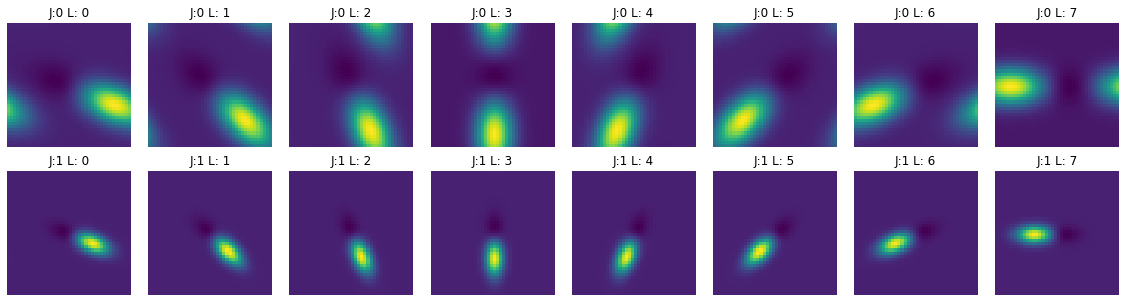

In [295]:
# show images before the otpimization
f, axarr = plt.subplots(2,8, figsize=(20, 5))
count = 0
for i in range(0, 2) :
    for j in range(0, 8) :
        axarr[i,j].imshow(np.fft.fftshift(psi[count][0].squeeze().cpu().detach().numpy()))
        axarr[i,j].axis('off')
        axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}")
        count = count +1
        axarr[i,j].set_xticklabels([])
        axarr[i,j].set_yticklabels([])
        axarr[i,j].set_aspect('equal')

f.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

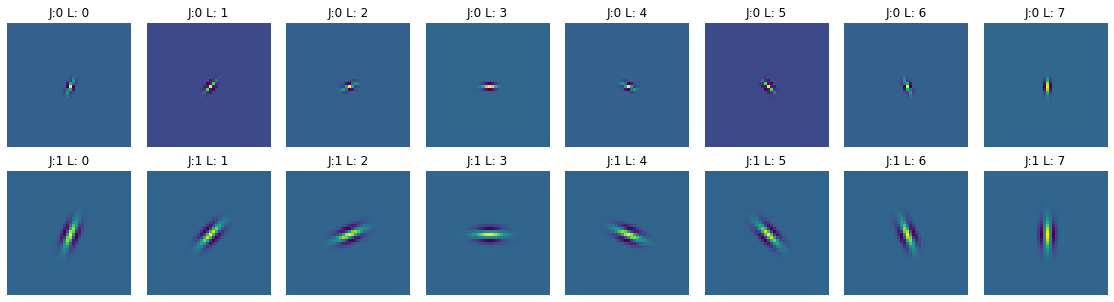

In [297]:
# show images after the optimization
f, axarr = plt.subplots(2,8, figsize=(20, 5))
count = 0
for i in range(0, 2) :
    for j in range(0, 8) :
        x= np.fft.fftshift(np.fft.ifft2(psi[count][0].squeeze().cpu().detach().numpy()))
        axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}")
        axarr[i,j].imshow(x.real)
        axarr[i,j].axis('off')
        count = count +1
        axarr[i,j].set_xticklabels([])
        axarr[i,j].set_yticklabels([])
        axarr[i,j].set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0.2)
plt.show()

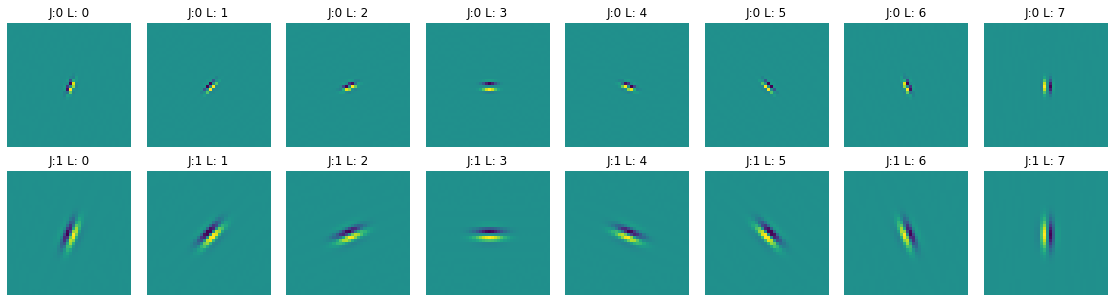

In [299]:
# show images after the optimization
f, axarr = plt.subplots(2,8, figsize=(20, 5))
count = 0
for i in range(0, 2) :
    for j in range(0, 8) :
        axarr[i,j].imshow(np.fft.fftshift(np.fft.ifft2(filters[count].squeeze().cpu().detach().numpy())).imag)
        axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}")
        axarr[i,j].axis('off')
        count = count +1
        axarr[i,j].set_xticklabels([])
        axarr[i,j].set_yticklabels([])
        axarr[i,j].set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0.2)
plt.show()

In [300]:
lr_scattering = 0.01
lr = 0.1
for epoch in range(0, 250):
    if epoch in drops or epoch==0:
        optimizer = torch.optim.SGD([{'params': filters, 'lr': lr_scattering}, 
                                    {'params': model.parameters()}], lr=lr, momentum=0.9,
                                    weight_decay=0.0005)
        lr*=0.2
        lr_scattering*=0.2

    train(model, device, train_loader, optimizer, epoch+1, scattering, psi)
    if epoch%10==0:
        test(model, device, test_loader, scattering, psi)


Train Epoch: 1 [0/500 (0%)]	Loss: 2.454628

Test set: Average loss: 29.5184, Accuracy: 1000/10000 (10.00%)

Train Epoch: 2 [0/500 (0%)]	Loss: 3.910785
Train Epoch: 3 [0/500 (0%)]	Loss: 2.312992
Train Epoch: 4 [0/500 (0%)]	Loss: 2.335388
Train Epoch: 5 [0/500 (0%)]	Loss: 2.293305
Train Epoch: 6 [0/500 (0%)]	Loss: 2.266682
Train Epoch: 7 [0/500 (0%)]	Loss: 2.283476
Train Epoch: 8 [0/500 (0%)]	Loss: 2.308353
Train Epoch: 9 [0/500 (0%)]	Loss: 2.297420
Train Epoch: 10 [0/500 (0%)]	Loss: 2.279207
Train Epoch: 11 [0/500 (0%)]	Loss: 2.235600

Test set: Average loss: 2.2780, Accuracy: 1421/10000 (14.21%)

Train Epoch: 12 [0/500 (0%)]	Loss: 2.275208
Train Epoch: 13 [0/500 (0%)]	Loss: 2.318969
Train Epoch: 14 [0/500 (0%)]	Loss: 2.192725
Train Epoch: 15 [0/500 (0%)]	Loss: 2.298131
Train Epoch: 16 [0/500 (0%)]	Loss: 2.256746
Train Epoch: 17 [0/500 (0%)]	Loss: 2.236539
Train Epoch: 18 [0/500 (0%)]	Loss: 2.267635
Train Epoch: 19 [0/500 (0%)]	Loss: 2.263261
Train Epoch: 20 [0/500 (0%)]	Loss: 2.251081


Train Epoch: 162 [0/500 (0%)]	Loss: 1.438443
Train Epoch: 163 [0/500 (0%)]	Loss: 1.263671
Train Epoch: 164 [0/500 (0%)]	Loss: 1.230083
Train Epoch: 165 [0/500 (0%)]	Loss: 1.110030
Train Epoch: 166 [0/500 (0%)]	Loss: 1.321522
Train Epoch: 167 [0/500 (0%)]	Loss: 1.148538
Train Epoch: 168 [0/500 (0%)]	Loss: 1.540388
Train Epoch: 169 [0/500 (0%)]	Loss: 1.432029
Train Epoch: 170 [0/500 (0%)]	Loss: 1.318841
Train Epoch: 171 [0/500 (0%)]	Loss: 1.109466

Test set: Average loss: 2.3806, Accuracy: 2696/10000 (26.96%)

Train Epoch: 172 [0/500 (0%)]	Loss: 0.923586
Train Epoch: 173 [0/500 (0%)]	Loss: 1.090655
Train Epoch: 174 [0/500 (0%)]	Loss: 1.173675
Train Epoch: 175 [0/500 (0%)]	Loss: 1.214188
Train Epoch: 176 [0/500 (0%)]	Loss: 1.295253
Train Epoch: 177 [0/500 (0%)]	Loss: 1.221381
Train Epoch: 178 [0/500 (0%)]	Loss: 0.985788
Train Epoch: 179 [0/500 (0%)]	Loss: 1.065375
Train Epoch: 180 [0/500 (0%)]	Loss: 1.137967
Train Epoch: 181 [0/500 (0%)]	Loss: 1.340738

Test set: Average loss: 2.3162, Acc

In [302]:
import pickle
with open('filters_250_epochs_0_01.pickle', 'wb') as handle:
    pickle.dump(filters, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [307]:
with open('filters_4000_epochs_0_01.pickle', 'rb') as handle:
    b = pickle.load(handle)

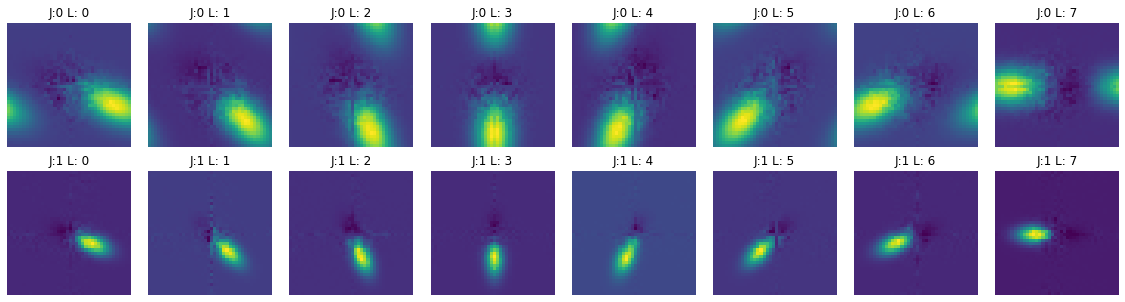

In [308]:
# show images before the otpimization
f, axarr = plt.subplots(2,8, figsize=(20, 5))
count = 0
for i in range(0, 2) :
    for j in range(0, 8) :
        axarr[i,j].imshow(np.fft.fftshift(b[count].squeeze().cpu().detach().numpy()))
        axarr[i,j].axis('off')
        axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}")
        count = count +1
        axarr[i,j].set_xticklabels([])
        axarr[i,j].set_yticklabels([])
        axarr[i,j].set_aspect('equal')

f.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

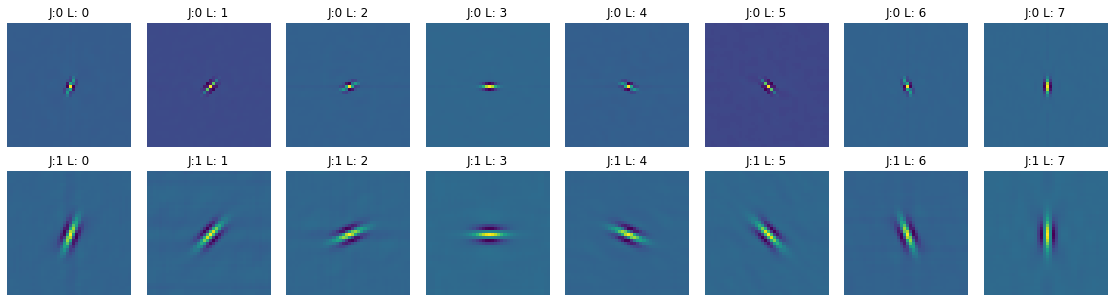

In [309]:
# show images after the optimization
f, axarr = plt.subplots(2,8, figsize=(20, 5))
count = 0
for i in range(0, 2) :
    for j in range(0, 8) :
        x= np.fft.fftshift(np.fft.ifft2(b[count].squeeze().cpu().detach().numpy()))
        axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}")
        axarr[i,j].imshow(x.real)
        axarr[i,j].axis('off')
        count = count +1
        axarr[i,j].set_xticklabels([])
        axarr[i,j].set_yticklabels([])
        axarr[i,j].set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0.2)
plt.show()

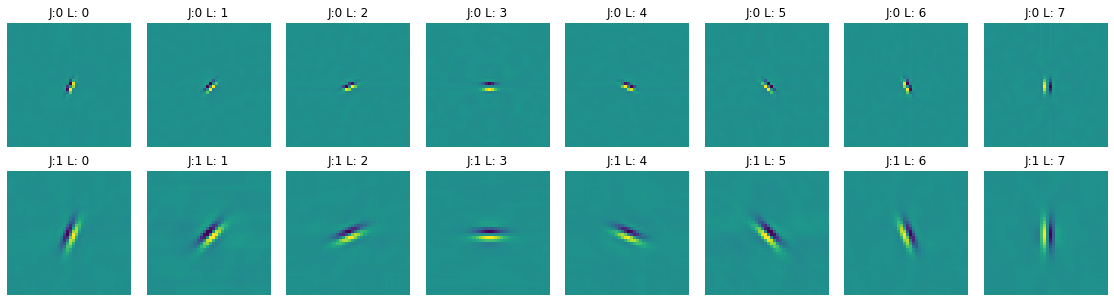

In [310]:
# show images after the optimization
f, axarr = plt.subplots(2,8, figsize=(20, 5))
count = 0
for i in range(0, 2) :
    for j in range(0, 8) :
        x= np.fft.fftshift(np.fft.ifft2(b[count].squeeze().cpu().detach().numpy()))
        axarr[i,j].set_title(f"J:{psi[count]['j']} L: {psi[count]['theta']}")
        axarr[i,j].imshow(x.imag)
        axarr[i,j].axis('off')
        count = count +1
        axarr[i,j].set_xticklabels([])
        axarr[i,j].set_yticklabels([])
        axarr[i,j].set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0.2)
plt.show()